# ECD-UY: Technical validation of the Electric water heater subset

This notebook presents the technical validation of the electric water heater subset, part of the ECD-UY data set.

## Load the needed libraries

In [5]:
# python
import datetime
from typing import List, Tuple, Union
import glob
from os.path import join, exists
from os import makedirs
import warnings
from datetime import datetime, timedelta

# data-science
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
import ciso8601

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print("Pandas version {}".format(pd.__version__))

Populating the interactive namespace from numpy and matplotlib
Pandas version 1.2.1


## Load data files

### Declare the path where the files are located

In [6]:
BASE_PATH = "../../../datasets/"

BASE_DATA_SOURCE = BASE_PATH + "/ECD-UY/electric-water-heater-subset"

### Load the appliance consumption data (without customers information)

In [7]:
fname = BASE_DATA_SOURCE + '/consumption_data_timers.csv'
data_appl_consum_timers = pd.read_csv(fname)
data_appl_consum_timers["datetime"] = pd.to_datetime(
    data_appl_consum_timers.datetime,
    unit='s',
    utc=True,
    cache=True
).dt.tz_convert('America/Montevideo')

print("Range of datetimes: {} to {}".format(data_appl_consum_timers.datetime.min(), data_appl_consum_timers.datetime.max()))
data_appl_consum_timers.head()

Range of datetimes: 2019-07-02 18:29:21-03:00 to 2020-10-26 17:33:03-03:00


,datetime,id,power,voltage
0,2019-07-02 18:29:21-03:00,866131033548393,0,223
1,2019-07-02 18:30:21-03:00,866131033548393,0,226
2,2019-07-02 18:31:21-03:00,866131033548393,0,226
3,2019-07-02 18:32:21-03:00,866131033548393,0,226
4,2019-07-02 18:33:21-03:00,866131033548393,0,226


In [9]:
data_appl_consum_timers.id.unique().shape

(102,)

### Load the appliance consumption data (with customers information)

In [10]:
fname = BASE_DATA_SOURCE + '/consumption_data_customers.csv'

data_appl_consum = pd.read_csv(
    fname,
)

In [11]:
data_appl_consum["datetime"] = pd.to_datetime(
    data_appl_consum.datetime,
    unit='s',
    utc=True,
    cache=True
).dt.tz_convert('America/Montevideo')

print("Range of datetimes: {} to {}".format(data_appl_consum.datetime.min(), data_appl_consum.datetime.max()))

data_appl_consum.head()

Range of datetimes: 2019-07-15 14:37:34-03:00 to 2020-10-26 17:33:03-03:00


,datetime,id,power,voltage
0,2019-07-15 14:37:34-03:00,115609,0,0
1,2019-07-15 14:38:34-03:00,115609,0,222
2,2019-07-15 14:39:34-03:00,115609,0,224
3,2019-07-15 14:40:34-03:00,115609,0,224
4,2019-07-15 14:41:34-03:00,115609,0,225


In [12]:
# Preserve electric water heater consumption as it is in the CSV files
data_appl_consum_original = data_appl_consum

(66158084, 4)


,datetime,id,power,voltage
0,2019-07-15 14:37:34-03:00,115609,0,0
1,2019-07-15 14:38:34-03:00,115609,0,222
2,2019-07-15 14:39:34-03:00,115609,0,224
3,2019-07-15 14:40:34-03:00,115609,0,224
4,2019-07-15 14:41:34-03:00,115609,0,225


<AxesSubplot:xlabel='datetime'>

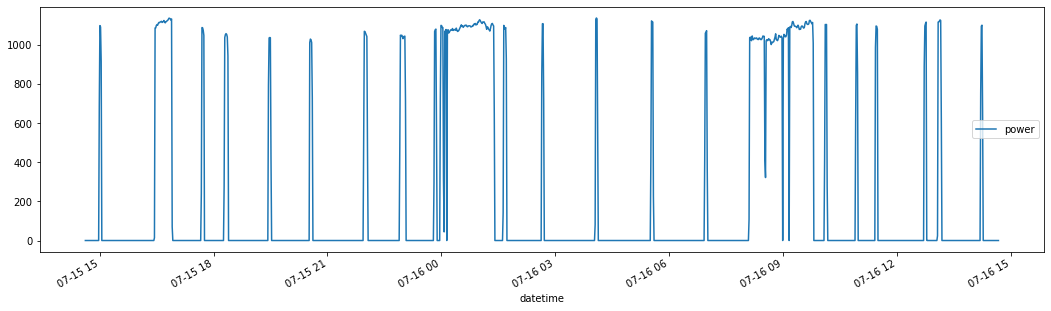

In [13]:

print(data_appl_consum.shape)
display(data_appl_consum[data_appl_consum.id==115609].head())
# Plot 24hs of records
data_appl_consum[data_appl_consum.id==115609].head(24*60)[["datetime", "power"]].plot(x="datetime", y="power")

In [14]:
# Unique customers/timers
print("Unique customers: {}\nUnique timers: {}".format(
    data_appl_consum.id.unique().shape[0],
    data_appl_consum_timers.id.unique().shape[0]
))

Unique customers: 166
Unique timers: 102


### Load the total consumption data

Records from the _Total household consumption_ subset were filtered according to the customer ids and datetime ranges present in the _Electric water heater_ subset.

In [15]:
filenames = glob.glob(BASE_DATA_SOURCE + '/../electric-water-heater-subset--total-consum/total_consumption_data_*.csv')

data_total_consum = [pd.read_csv(
    fname,
    names=["datetime", "id", "value"],
    parse_dates=["datetime"],
    date_parser=lambda epoch: pd.Timestamp(int(epoch), unit='s', tz='America/Montevideo'),
    cache_dates=True,
) for fname in filenames]

data_total_consum = pd.concat(data_total_consum, ignore_index=True)
data_total_consum.sort_values("datetime", inplace=True)

data_total_consum.head()

,datetime,id,value
1168689,2019-07-01 00:00:00-03:00,109961,0.382
1168800,2019-07-01 00:00:00-03:00,62423,0.014
1168801,2019-07-01 00:00:00-03:00,157359,0.043
1168802,2019-07-01 00:00:00-03:00,151471,0.016
1168803,2019-07-01 00:00:00-03:00,17881,0.031


In [16]:
data_total_consum.id.unique().shape[0]

145

In [66]:
len(set(data_total_consum.id.unique()) & set(data_appl_consum.id.unique()))

135

## Data correctness analysis

Statistical characteristics about the values are analyzed and the percentile is plotted in several values to visualize the outliers.

### Total consumption

In [17]:
print("meadian\t\t{}".format(data_total_consum.value.median()))
print("meadian (>0)\t{}".format(data_total_consum[data_total_consum.value>0].value.median()))
print("mean (>0)\t{}".format(data_total_consum[data_total_consum.value>0].value.mean()))
print(data_total_consum.value.describe())

meadian		0.054
meadian (>0)	0.054
mean (>0)	0.1308692483580126
count    2.679620e+06
mean     1.302699e-01
std      1.858685e-01
min      0.000000e+00
25%      2.500000e-02
50%      5.400000e-02
75%      1.510000e-01
max      9.925000e+00
Name: value, dtype: float64


Text(0.5, 1.0, 'Quantiles of the active in energy values')

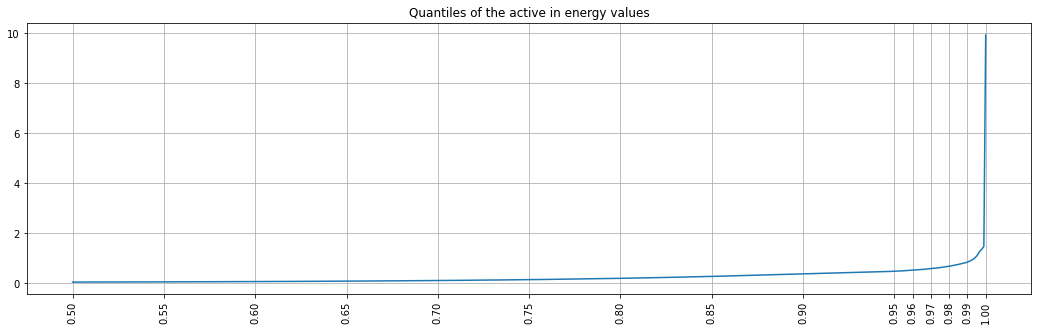

In [18]:
data_total_consum.value.quantile([x/1000 for x in range(500,1001)]).plot(rot=90, grid=True)
plt.xticks([x/20 for x in range(10,21)]+[.96, .97,.98,.99])
plt.title("Quantiles of the active in energy values")

NOTE: For percentile greater than 0.99(9), some values looks too big. Denotes probable precense of outliers.

In [19]:
data_total_consum[data_total_consum.value > data_total_consum.value.quantile(.99999)].sort_values("value", ascending=False).head(15)

,datetime,id,value
2570520,2019-08-25 00:00:00-03:00,69806,9.925
2570458,2019-08-25 00:00:00-03:00,69806,9.925
2586515,2019-08-26 00:00:00-03:00,69806,9.687
2586571,2019-08-26 00:00:00-03:00,69806,9.687
2602683,2019-08-27 00:00:00-03:00,69806,6.934
2602739,2019-08-27 00:00:00-03:00,69806,6.934
2031933,2019-09-23 00:00:00-03:00,69806,6.649
2031992,2019-09-23 00:00:00-03:00,69806,6.649
2015076,2019-09-22 00:00:00-03:00,69806,5.124
2015134,2019-09-22 00:00:00-03:00,69806,5.124


Note: Looks like there is a cut for values over 2.186, and all of them are recorded in the same customer (#69806).

### Electric water heater consumption

In [20]:
print("meadian\t\t{}".format(data_appl_consum.power.median()))
print("meadian (>0)\t{}".format(data_appl_consum[data_appl_consum.power>0].power.median()))
print(data_appl_consum.power.describe())

meadian		0.0
meadian (>0)	1291.0
count    6.615808e+07
mean     1.467257e+02
std      4.129383e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.329000e+03
Name: power, dtype: float64


Text(0.5, 1.0, 'Quantiles of the power (W) values of the appliance consumption')

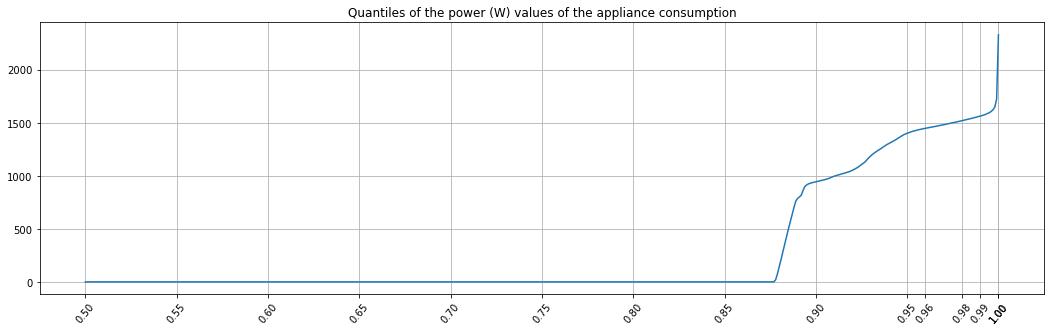

In [21]:
data_appl_consum.power.quantile([x/1000 for x in range(500,1001)]).plot(rot=50, grid=True)
plt.xticks([x/20 for x in range(10,21)]+[.96,.98,.99, 1])
plt.title("Quantiles of the power (W) values of the appliance consumption")

Note: Highest values are not so high. It is necessary to calculate percentiles per appliance and remove outliners if necessary.

## Remove outliers and resample/refill to exactly one-minute samples

Note: Reconstructed records (gaps or outliers) are marked with a boolean value in the column 'reconstructed'.

### Example of outliner in total consumption

In [22]:
# Plot a month of total records
data_total_consum_before_corrections = data_total_consum[
    (data_total_consum.datetime.dt.month==9)
][data_total_consum.id==69806][["datetime", "value"]]

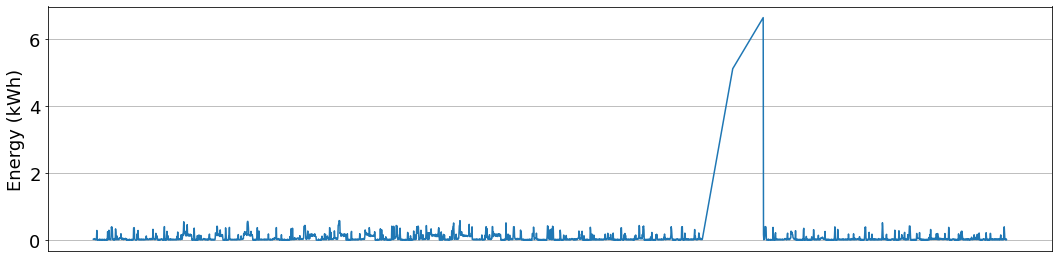

In [23]:
plt.rcParams.update({'font.size': 18})

data_total_consum_before_corrections.plot(
    x="datetime", y="value",
    legend=False,
    grid=True,
    rot=0,
)

plt.xlabel(None)
plt.ylabel("Energy (kWh)")

_ = plt.xticks([])

### Example of outliner in electric water heater consumption

In [24]:
# Plot 24hs of appliance records
data_appl_consum_before_correction = data_appl_consum[
    (data_appl_consum.datetime.dt.month==8) &
    (data_appl_consum.datetime.dt.day==1)
][data_appl_consum.id==115609].head(24*60)[["datetime", "power"]]

Text(0, 0.5, 'Power (W)')

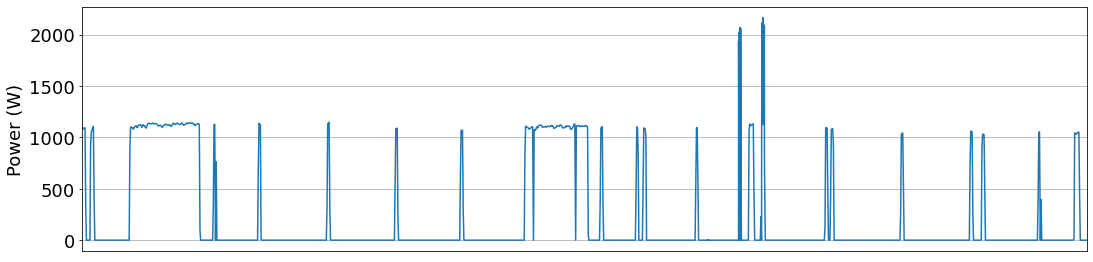

In [25]:
plt.rcParams.update({'font.size': 18})
# plt.margins(x=0)
plt.rcParams['axes.xmargin'] = 0

data_appl_consum_before_correction[["datetime", "power"]].plot(
    x="datetime", y="power",
    legend=False,
    grid=True,
    rot=0,
)

_ = plt.xticks([])
plt.xlabel(None)
plt.ylabel("Power (W)")

### Remove outliers

In [26]:
print("Rows before removing outliers: {}".format(data_total_consum.shape[0]))
data_total_consum.drop(data_total_consum[data_total_consum.value > 2.186].index, inplace=True)
print("Rows after removing outliers: {}".format(data_total_consum.shape[0]))

Rows before removing outliers: 2679620
Rows after removing outliers: 2679610


In [27]:
print("Rows before removing outliers: {}".format(data_appl_consum.shape[0]))
data_appl_consum = data_appl_consum.groupby("id").apply(lambda g: g[g.power<g.power.quantile(.99)])
print("Rows after removing outliers: {}".format(data_appl_consum.shape[0]))

Rows before removing outliers: 66158084
Rows after removing outliers: 65356358


#### Example after removing outliner in total consumption

<AxesSubplot:xlabel='datetime'>

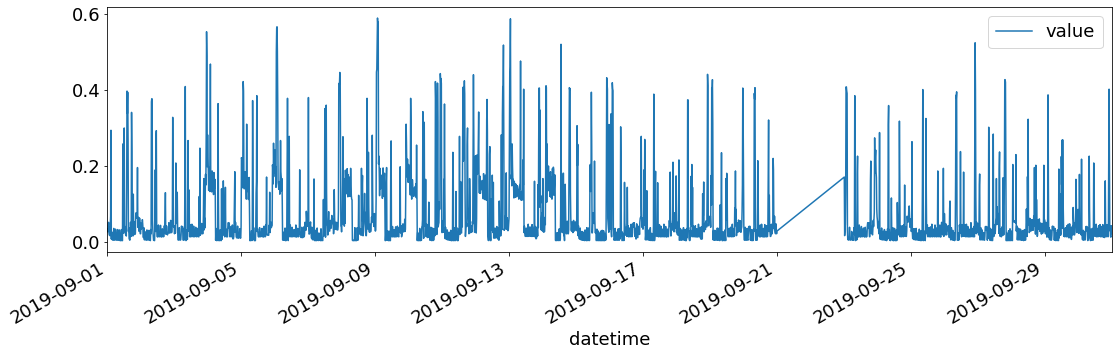

In [28]:
# Plot 24hs of total records
data_total_consum[
    (data_total_consum.datetime.dt.month==9)
][data_total_consum.id==69806][["datetime", "value"]].plot(x="datetime", y="value")

#### Example after removing outliner in electric water heater consumption

<AxesSubplot:xlabel='datetime'>

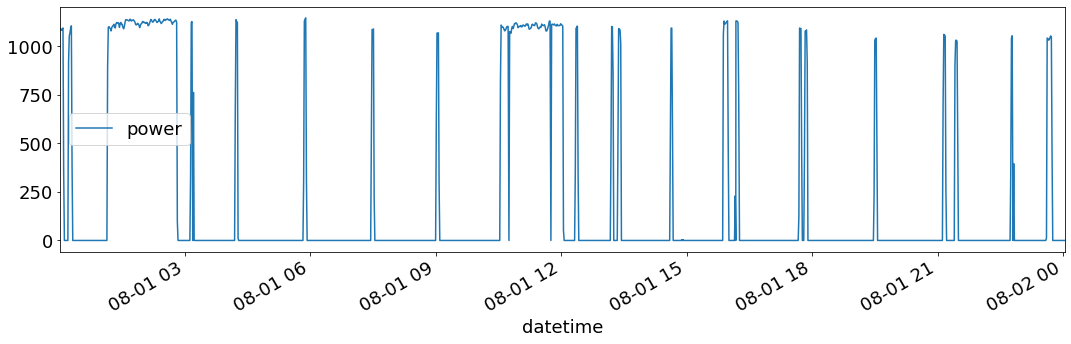

In [29]:
# Plot 24hs of appliance records
data_appl_consum[data_appl_consum.datetime.dt.month==8][data_appl_consum.id==115609].head(24*60)[["datetime", "power"]].plot(x="datetime", y="power")

### Resample and refilling

Total consumption is resampled to 15 minutes samples and electric water heater consumption is resampled to one minute. The gaps are refilled with zero values.

In [30]:
data_appl_consum_dt = data_appl_consum.groupby([
    data_appl_consum.id,
    data_appl_consum.datetime.dt.year
]).agg({"datetime": ["min", "max", "count", lambda x: x.count() / 1440]})
data_appl_consum_dt.head(20)

datetime                                    \
                                    min                       max   count   
id   datetime                                                               
2473 2019     2019-07-30 12:13:56-03:00 2019-12-31 23:59:17-03:00    6086   
     2020     2020-01-01 00:00:17-03:00 2020-10-26 17:32:48-03:00  380237   
4729 2019     2019-07-29 11:40:47-03:00 2019-12-31 23:59:32-03:00   89112   
     2020     2020-01-01 00:00:32-03:00 2020-10-26 17:32:57-03:00  420808   
7132 2019     2019-07-31 12:23:49-03:00 2019-10-17 15:44:09-03:00      83   
     2020     2020-03-02 10:57:51-03:00 2020-10-26 17:32:43-03:00  335614   
7484 2019     2019-08-05 16:34:43-03:00 2019-12-27 10:02:18-03:00  171259   
     2020     2020-01-08 10:00:39-03:00 2020-03-16 17:41:38-03:00   72755   
7722 2019     2019-08-05 16:24:34-03:00 2019-12-31 23:59:04-03:00  132320   
     2020     2020-01-01 00:00:04-03:00 2020-10-26 17:32:49-03:00  422323   
7725 2019     2019-08-05 16:22:03-03:00 2019-12-31 23:59:36-03:00  149040   
     2020     2020-01-01 00:00:36-03:00 2020-10-26 17:32:53-03:00  424649   
7728 2019     2019-08-07 12:17:23-03:00 2019-12-31 23:59:20-03:00  196977   
     2020     2020-01-01 00:00:25-03:00 2020-10-26 17:33:02-03:00  425431   
7729 2019     2019-08-08 15:29:02-03:00 2019-12-31 23:59:31-03:00  147350   
     2020     2020-01-01 00:00:31-03:00 2020-10-16 08:33:12-03:00  410207   
7967 2019     2019-08-08 10:05:26-03:00 2019-12-31 23:59:07-03:00  160157   
     2020     2020-01-01 00:00:10-03:00 2020-10-26 17:32:21-03:00  413067   
7968 2019     2019-08-07 14:19:37-03:00 2019-12-31 23:59:30-03:00  195067   
     2020     2020-01-01 00:00:30-03:00 2020-10-23 22:44:33-03:00  323968   

                           
               <lambda_0>  
id   datetime              
2473 2019        4.226389  
     2020      264.053472  
4729 2019       61.883333  
     2020      292.227778  
7132 2019        0.057639  
     2020      233.065278  
7484 2019      118.929861  
     2020       50.524306  
7722 2019       91.888889  
     2020      293.279861  
7725 2019      103.500000  
     2020      294.895139  
7728 2019      136.789583  
     2020      295.438194  
7729 2019      102.326389  
     2020      284.865972  
7967 2019      111.220139  
     2020      286.852083  
7968 2019      135.463194  
     2020      224.977778

In [31]:
data_appl_consum_dt[data_appl_consum_dt.index.get_level_values('id')==115609]

datetime                                    \
                                      min                       max   count   
id     datetime                                                               
115609 2019     2019-07-15 14:37:34-03:00 2019-11-26 17:46:24-03:00   67160   
       2020     2020-01-30 14:13:31-03:00 2020-10-26 17:32:41-03:00  381908   

                             
                 <lambda_0>  
id     datetime              
115609 2019       46.638889  
       2020      265.213889

In [32]:
data_appl_consum = data_appl_consum.groupby(data_appl_consum.id).resample('1min', on='datetime').mean()

In [33]:
data_appl_consum["reconstructed"] = (data_appl_consum.power.isna()) | (data_appl_consum.voltage.isna())
data_appl_consum.fillna(0, inplace=True)
data_appl_consum.drop("id", axis="columns", inplace=True)
data_appl_consum.reset_index(inplace=True)

In [34]:
data_total_consum = data_total_consum.groupby(data_total_consum.id).resample('15min', on='datetime').mean()

In [35]:
data_total_consum["reconstructed"] = data_total_consum.value.isna()
data_total_consum.fillna(0, inplace=True)
data_total_consum.drop(["id"], axis="columns", inplace=True)
data_total_consum.reset_index(inplace=True)

#### Example after resample/refilling the total consumption data

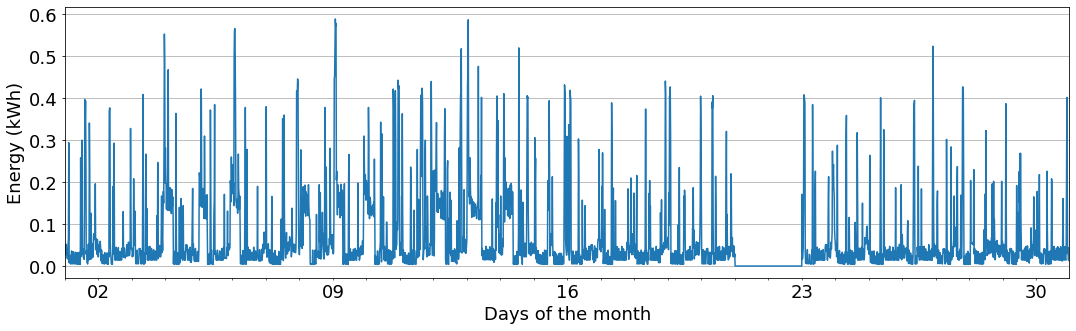

In [36]:
plt.rcParams.update({'font.size': 18})

# Plot a month of total records
data_total_consum[
    (data_total_consum.datetime.dt.year==2019) &
    (data_total_consum.datetime.dt.month==9)
][data_total_consum.id==69806][["datetime", "value"]].plot(
    x="datetime", y="value",
    legend=False,
    grid=True,
)

plt.xlabel("Days of the month")
plt.ylabel("Energy (kWh)")

_ = plt.xticks([])

#### Example after resample/refilling the electric water heater consumption data

Text(0, 0.5, 'Power (W)')

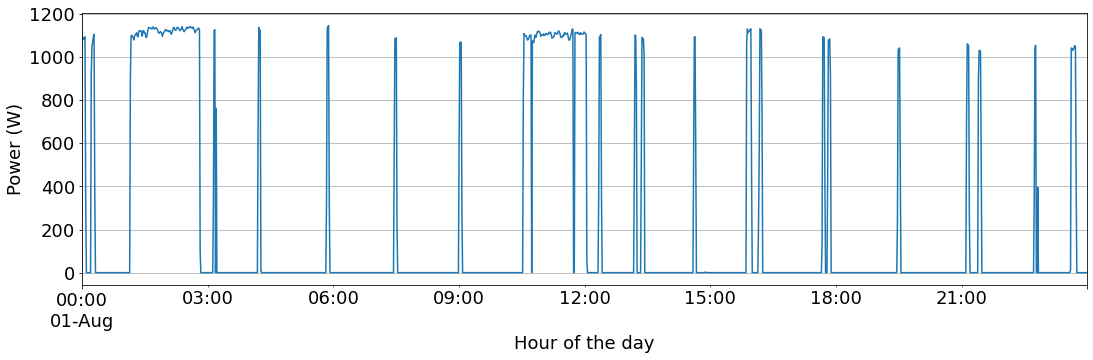

In [37]:
plt.rcParams.update({'font.size': 18})

# Plot 24hs of appliance records
data_appl_consum[
    (data_appl_consum.datetime.dt.year==2019) &
    (data_appl_consum.datetime.dt.month==8) &
    (data_appl_consum.datetime.dt.day==1)
][data_appl_consum.id==115609][["datetime", "power"]].plot(
    x="datetime", y="power",
    legend=False,
    grid=True,
)

plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")

### Plot two different case of use of electric water heater

#### Calculate accumulated consumption, number of reconstructed records and ON intervals, for day-customer

In [38]:
def count_ON_intervals(x):
    x[x>0] = 1
    return (x * (x != x.shift())).sum()

data_appl_consum_sumpower_day = data_appl_consum[
    (data_appl_consum.datetime.dt.year==2019)
].groupby([
    data_appl_consum.id, data_appl_consum.datetime.dt.date
]).agg(
    total_records=pd.NamedAgg(column="power", aggfunc="count"),
    total_consum=pd.NamedAgg(column="power", aggfunc="sum"),
    total_reconstructed=pd.NamedAgg(column="reconstructed", aggfunc="sum"),
    ON_intervals=pd.NamedAgg(column="power", aggfunc=count_ON_intervals),
)

data_appl_consum_sumpower_day.head()


total_records  total_consum  total_reconstructed  \
id   datetime                                                       
2473 2019-07-30            707           0.0                  705   
     2019-07-31           1440           0.0                 1440   
     2019-08-01           1440           0.0                 1440   
     2019-08-02           1440           0.0                 1440   
     2019-08-03           1440           0.0                 1440   

                 ON_intervals  
id   datetime                  
2473 2019-07-30           0.0  
     2019-07-31           0.0  
     2019-08-01           0.0  
     2019-08-02           0.0  
     2019-08-03           0.0

In [39]:
data_appl_consum_sumpower_day[data_appl_consum_sumpower_day.total_consum>0].total_consum.mean()

159314.1841599504

#### Look for cases of a unique ON interval, with moderate consumption

In [40]:
data_appl_consum_sumpower_day[
    (data_appl_consum_sumpower_day.ON_intervals==1) &
    (data_appl_consum_sumpower_day.total_consum>100000) &
    (data_appl_consum_sumpower_day.total_reconstructed<144)
]

total_records  total_consum  total_reconstructed  \
id    datetime                                                       
7967  2019-11-03           1440      121941.0                    5   
10581 2019-10-07           1440      126314.0                   20   
      2019-11-09           1440      120653.0                    9   
      2019-11-15           1440      100565.0                    6   
28805 2019-10-31           1440      163235.0                    6   
      2019-11-20           1440      103806.0                    5   
      2019-11-21           1440      102067.0                    5   
      2019-11-22           1440      136910.0                    3   
      2019-11-23           1440      128157.0                    3   
      2019-11-24           1440      137366.0                    4   
37445 2019-10-19           1440      135637.0                    4   
      2019-11-20           1440      108245.0                    7   
65374 2019-11-02           1440      170770.0                   10   
      2019-11-03           1440      215456.0                    7   
      2019-11-11           1440      121397.0                   10   
      2019-11-18           1440      219766.0                    3   
      2019-12-01           1440      170832.0                    5   
      2019-12-09           1440      182837.0                    6   

                  ON_intervals  
id    datetime                  
7967  2019-11-03           1.0  
10581 2019-10-07           1.0  
      2019-11-09           1.0  
      2019-11-15           1.0  
28805 2019-10-31           1.0  
      2019-11-20           1.0  
      2019-11-21           1.0  
      2019-11-22           1.0  
      2019-11-23           1.0  
      2019-11-24           1.0  
37445 2019-10-19           1.0  
      2019-11-20           1.0  
65374 2019-11-02           1.0  
      2019-11-03           1.0  
      2019-11-11           1.0  
      2019-11-18           1.0  
      2019-12-01           1.0  
      2019-12-09           1.0

#### Plot specific-use case

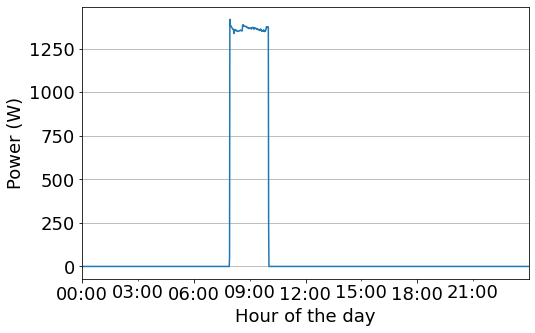

In [41]:
plt.rcParams['axes.xmargin'] = 0

tmp = data_appl_consum[
    (data_appl_consum.id==65374) &
    (data_appl_consum.datetime.dt.year==2019) &
    (data_appl_consum.datetime.dt.month==11) &
    (data_appl_consum.datetime.dt.day==2)
]
ax = tmp[["datetime", "power"]].plot(
    x="datetime", y="power",
    legend=False,
    grid=True,
    figsize=(8, 5),
)
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")
ax.grid(axis='x')

_ = plt.xticks(
    [tmp.datetime.iloc[x] for x in range(0, 1440, 360)],
    ["{:02d}:{:02d}".format(i, 0) for i in range(0,24, 6)],
    rotation=0
)

#### Look for high consumption case with several ON intervals

In [42]:
data_appl_consum_sumpower_day[
    (data_appl_consum_sumpower_day.ON_intervals>10) &
    (data_appl_consum_sumpower_day.total_consum>159052) &  # Greater than average consumption
    (data_appl_consum_sumpower_day.total_reconstructed<144)
].head()

total_records  total_consum  total_reconstructed  \
id   datetime                                                       
4729 2019-10-30           1440      204675.0                    7   
     2019-11-02           1440      212131.0                    8   
     2019-11-03           1440      235270.0                    7   
     2019-11-04           1440      232777.0                   20   
     2019-11-07           1440      164961.0                   25   

                 ON_intervals  
id   datetime                  
4729 2019-10-30          15.0  
     2019-11-02          14.0  
     2019-11-03          11.0  
     2019-11-04          13.0  
     2019-11-07          14.0

#### Plot an always ON case

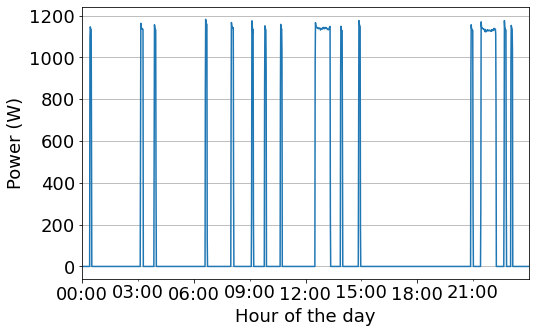

In [43]:
plt.rcParams['axes.xmargin'] = 0

tmp = data_appl_consum[
    (data_appl_consum.id==4729) &
    (data_appl_consum.datetime.dt.year==2019) &
    (data_appl_consum.datetime.dt.month==10) &
    (data_appl_consum.datetime.dt.day==30)
]
ax = tmp[["datetime", "power"]].plot(
    x="datetime", y="power",
    legend=False,
    grid=True,
    figsize=(8, 5),
)
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")
ax.grid(axis='x')

_ = plt.xticks(
    [tmp.datetime.iloc[x] for x in range(0, 1440, 360)],
    ["{:02d}:{:02d}".format(i, 0) for i in range(0,24, 6)],
    rotation=0
)

### Plot a the total/appliance consumption for a customer

In [44]:
# Look for a customer with complete total/appliance consumption records in the month 8
data_appl_consum[data_appl_consum.datetime.dt.month==8].groupby([
    data_appl_consum.id,
    data_appl_consum.datetime.dt.date
]).count().sort_values("power", ascending=False).head()

id  datetime  power  voltage  reconstructed
id    datetime                                                 
2473  2019-08-01  1440      1440   1440     1440           1440
69806 2019-08-17  1440      1440   1440     1440           1440
      2019-08-19  1440      1440   1440     1440           1440
      2019-08-20  1440      1440   1440     1440           1440
      2019-08-21  1440      1440   1440     1440           1440

Text(0, 0.5, 'Power (W)')

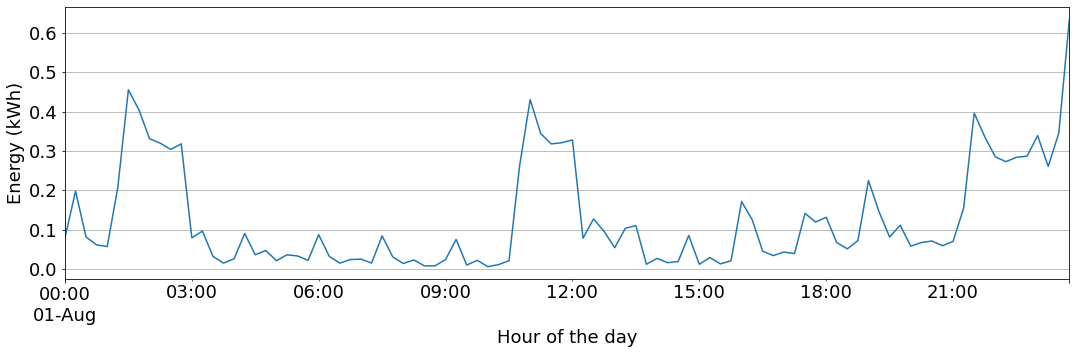

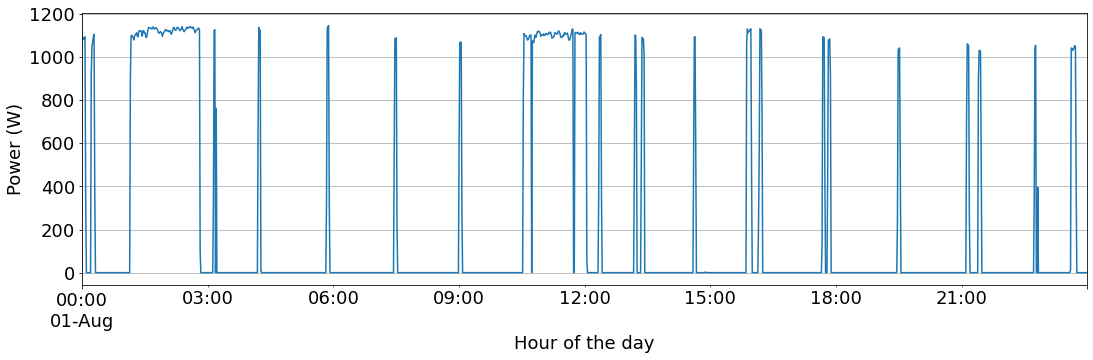

In [45]:
plt.rcParams.update({'font.size': 18})

# display(display(data_total_consum[data_total_consum.datetime.dt.month==8][data_total_consum.id==115609].drop_duplicates().head()))
# Plot 24hs of total consumption records
data_total_consum[
    (data_total_consum.datetime.dt.year==2019) &
    (data_total_consum.datetime.dt.month==8) &
    (data_total_consum.datetime.dt.day==1)
][data_total_consum.id==115609].drop_duplicates().head(24*4)[["datetime", "value"]].plot(
    x="datetime", y="value",
    legend=False,
    grid=True,
)
plt.xlabel("Hour of the day")
plt.ylabel("Energy (kWh)")

# display(data_appl_consum[data_appl_consum.datetime.dt.month==8][data_appl_consum.id==115609].head())
# Plot 24hs of total appliance records
data_appl_consum[
    (data_appl_consum.datetime.dt.year==2019) &
    (data_appl_consum.datetime.dt.month==8) &
    (data_appl_consum.datetime.dt.day==1)
][data_appl_consum.id==115609].head(24*60)[["datetime", "power"]].plot(
    x="datetime", y="power",
    legend=False,
    grid=True,
)
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")

## Technical validation

### Consumption stats

#### Average total and appliance power consumption for every 15 minutes of the day

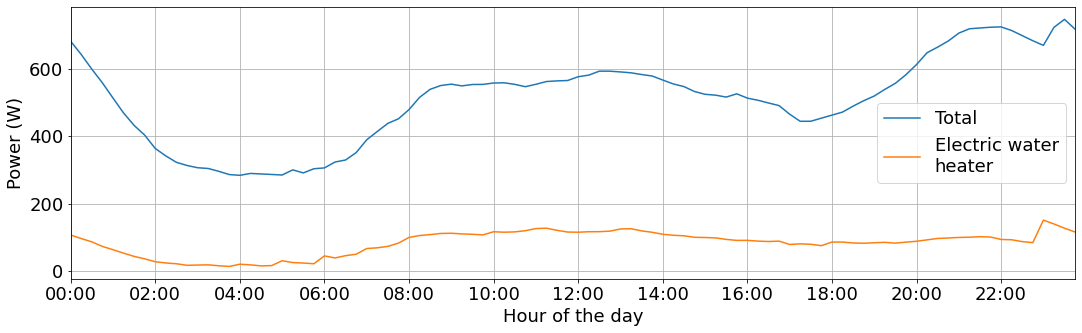

In [46]:
plt.rcParams.update({'font.size': 18})

data_total_consum_tmp = data_total_consum[["datetime", "value"]].resample("15min", on="datetime").mean()
data_total_consum_tmp = ((data_total_consum_tmp.groupby(
    [data_total_consum_tmp.index.hour, data_total_consum_tmp.index.minute]
).mean()*1000)/0.25)
ax = data_total_consum_tmp.plot(
    grid=True,
)

data_appl_consum_tmp = data_appl_consum[["datetime", "power"]].resample("15min", on="datetime").mean()
data_appl_consum_tmp = data_appl_consum_tmp.groupby(
    [data_appl_consum_tmp.index.hour, data_appl_consum_tmp.index.minute]
).mean()
data_appl_consum_tmp.plot(
    grid=True, ax=ax
)



# plt.title("Total and electric water heater 15-minutes average power consumption.")
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")
plt.legend(['Total', 'Electric water\nheater'])
_ = plt.xticks(
    range(0,96,8),
    ["{:02d}:{:02d}".format(i, j) for i in range(0,24, 2) for j in range(0,60, 60)],
    rotation=0
)

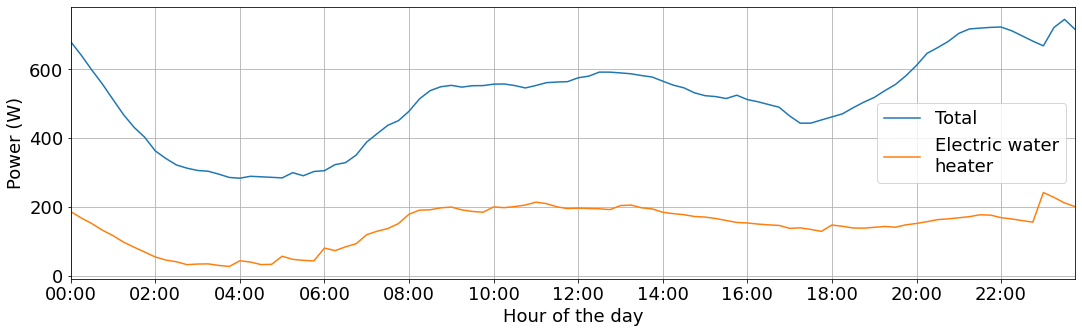

In [47]:
plt.rcParams.update({'font.size': 18})

# data_total_consum_tmp comes from the previous cell
ax = data_total_consum_tmp.plot(
    grid=True,
)

data_appl_consum_original_tmp = data_appl_consum_original[["datetime", "power"]].resample("15min", on="datetime").mean()
data_appl_consum_original_tmp = data_appl_consum_original_tmp.groupby(
    [data_appl_consum_original_tmp.index.hour, data_appl_consum_original_tmp.index.minute]
).mean()
data_appl_consum_original_tmp.plot(
    grid=True, ax=ax
)


# plt.title("Total and electric water heater 15-minutes average power consumption.")
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")
plt.legend(['Total', 'Electric water\nheater'])
_ = plt.xticks(
    range(0,96,8),
    ["{:02d}:{:02d}".format(i, j) for i in range(0,24, 2) for j in range(0,60, 60)],
    rotation=0
)

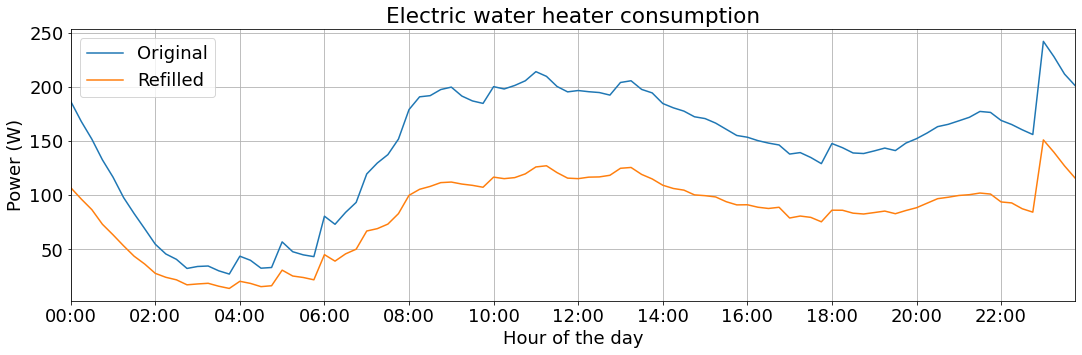

In [48]:
# data_appl_consum_original_tmp comes from previous cells
ax = data_appl_consum_original_tmp.plot(
    grid=True,
)

# data_appl_consum_tmp comes from previous cells
data_appl_consum_tmp.plot(
    grid=True, ax=ax
)

plt.title("Electric water heater consumption")
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")
plt.legend(['Original', 'Refilled'])
_ = plt.xticks(
    range(0,96,8),
    ["{:02d}:{:02d}".format(i, j) for i in range(0,24, 2) for j in range(0,60, 60)],
    rotation=0
)

27.07403723956644


<AxesSubplot:xlabel='datetime,datetime'>

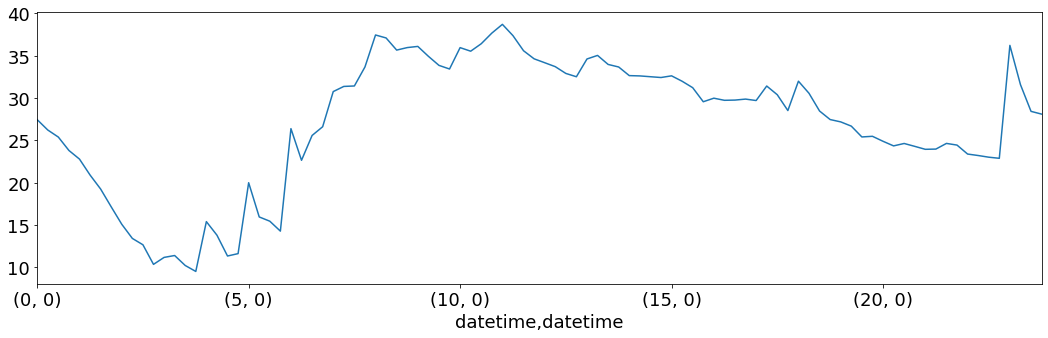

In [49]:
print(((data_appl_consum_original_tmp["power"] * 100) / data_total_consum_tmp["value"]).mean())
((data_appl_consum_original_tmp["power"] * 100) / data_total_consum_tmp["value"]).plot()

15.556958136063132


<AxesSubplot:xlabel='datetime,datetime'>

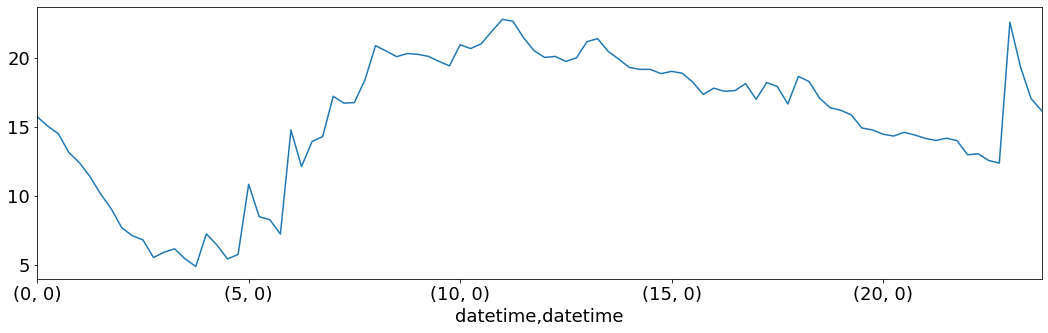

In [50]:
print(((data_appl_consum_tmp["power"] * 100) / data_total_consum_tmp["value"]).mean())
((data_appl_consum_tmp["power"] * 100) / data_total_consum_tmp["value"]).plot()

#### Average total and appliance power consumption for every 1 hour of the day

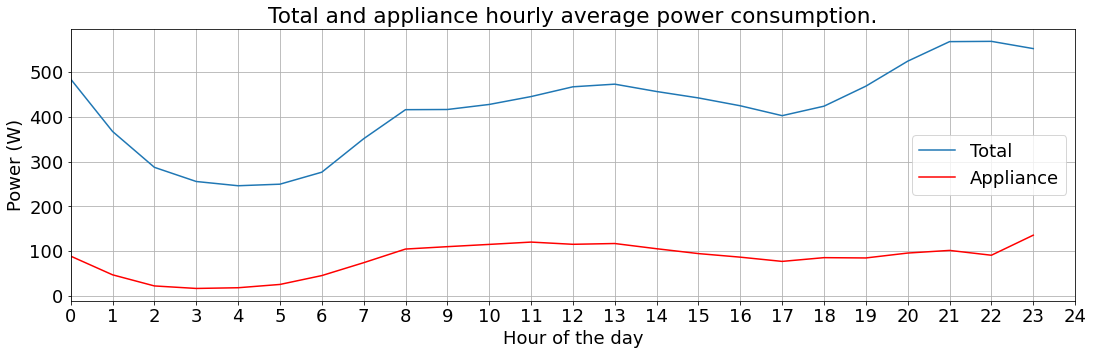

In [51]:
plt.rcParams.update({'font.size': 18})

fig = plt.Figure()

ax = ((data_total_consum[
    (data_total_consum.value >= 0) & 
    (data_total_consum.value < data_total_consum.value.quantile(.97))
].groupby(data_total_consum.datetime.dt.hour)['value'].mean()*1000)/0.25).plot(
    legend=True,
    label="Total",
    sharex=True,
    sharey=False,
    grid=True,
)

data_appl_consum.groupby(data_appl_consum.datetime.dt.hour)['power'].mean().plot(
    ax=ax,
    legend=True,
    label="Appliance",
    ylabel="Power (W)",
    sharex=True,
    sharey=False,
    color='red',
    grid=True,
)

plt.title("Total and appliance hourly average power consumption.")
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")
plt.legend(['Total', 'Appliance'])
_ = plt.xticks(np.arange(25))

#### Average appliance power consumption per minute of the day

Text(0, 0.5, 'Power (W)')

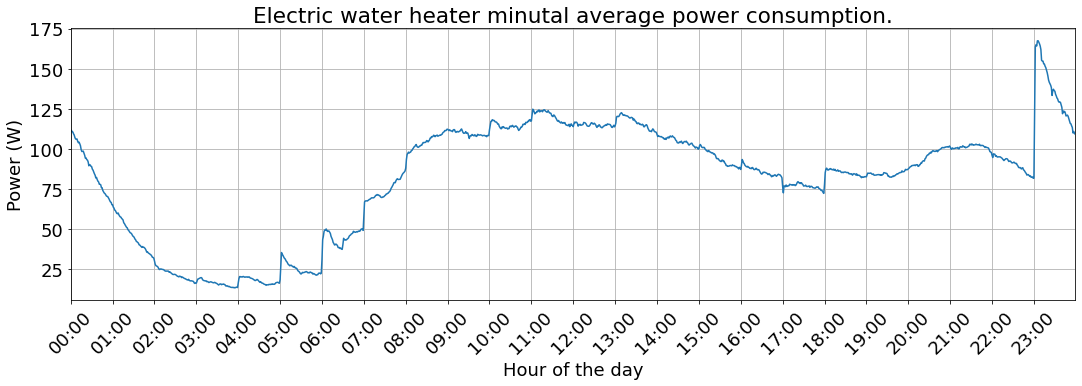

In [52]:
plt.rcParams.update({'font.size': 18})

data_appl_consum[["datetime", "power"]].groupby(
    [data_appl_consum.datetime.dt.hour, data_appl_consum.datetime.dt.minute]
).mean().plot(
    grid=True,
    legend=False
)
_ = plt.xticks(
    list(range(0,1440,60)),
    ["{:02d}:{:02d}".format(i, j) for i in range(0,24) for j in range(0,60, 60)],
    rotation=45
)

plt.title("Electric water heater minutal average power consumption.")
plt.xlabel("Hour of the day")
plt.ylabel("Power (W)")

## Customers geo-distribution

### Load customers and geo data

In [53]:
data_customers = pd.read_csv(
    BASE_DATA_SOURCE + '/customers.csv',
)
data_customers.head()

,customer_id,tension,tariff,power,department,section,segment,zone
0,2,BT 230 V,TCB,3700,3,5,4,19
1,3,BT 230 V,TRS,2200,3,4,14,7
2,5,BT 230 V,TRS,2200,13,3,303,19
3,6,BT 230 V,TCB,3700,19,1,124,800
4,9,BT 230 V,TCB,3700,15,8,302,600


In [54]:
# Filter by customers with electric-water-heater consumption
data_customers = pd.merge(
    data_customers,
    pd.DataFrame(data=data_appl_consum.id.unique(), columns=["customer_id"]),
)
data_customers.head()

,customer_id,tension,tariff,power,department,section,segment,zone
0,2473,BT 230 V,TRD,3700,1,10,225,8
1,4729,BT 230 V,TRS,4600,1,12,220,18
2,7132,BT 230 V,TRD,3700,1,10,338,29
3,7484,BT 230 V,TRS,7400,1,12,220,18
4,7722,BT 230 V,TRS,2500,1,12,220,18


In [55]:
MAPS_PATH = BASE_PATH + "/maps-INE-UY-2011"

# import geopandas
import geopandas as gpd
from geopandas import GeoDataFrame

# Coordinates system (used by INE) -> http://www.spatialreference.org/ref/epsg/wgs-84-utm-zone-21s/
# EPSG:32721
crs = {'init': 'epsg:32721'}

# Departments
filePath = MAPS_PATH + "/ine_depto.shp"
geoSecUY = GeoDataFrame.from_file(filePath, crs=crs)

# Sections
filePath = MAPS_PATH + "/ine_seccen.shp"
geoSecUY = GeoDataFrame.from_file(filePath, crs=crs)
geoSecMvd = geoSecUY[geoSecUY.DEPTO == 1]

geoSecMvd.head()

,AREA,PERIMETER,DEPTO,SECCION,CODSEC,NOMBDEPTO,CDEPTO_ISO,geometry
0,590829.693632,3320.439484,1,1,101,MONTEVIDEO,UYMO,"POLYGON ((572996.182 6137079.102, 573001.001 6..."
1,482430.942858,4943.780584,1,2,102,MONTEVIDEO,UYMO,"POLYGON ((572148.265 6136842.960, 572058.138 6..."
2,421107.977409,3805.106086,1,3,103,MONTEVIDEO,UYMO,"POLYGON ((572708.280 6136734.810, 572708.878 6..."
3,565182.336203,3851.337776,1,4,104,MONTEVIDEO,UYMO,"POLYGON ((573700.716 6136661.089, 573708.024 6..."
4,840787.213347,4471.698384,1,5,105,MONTEVIDEO,UYMO,"POLYGON ((574375.309 6136018.838, 574375.797 6..."


### Calculate customers per census areas

In [56]:
cust_by_dep = data_customers[["department", "customer_id"]].groupby("department").count()
cust_by_sec = data_customers[["department", "section", "customer_id"]].groupby(
    ["department", "section"]
).count()
cust_by_seg = data_customers[["department", "section", "segment", "customer_id"]].groupby(
    ["department", "section", "segment"]
).count()

In [57]:
display(cust_by_dep)
display(geoSecUY[["DEPTO", "NOMBDEPTO"]].drop_duplicates())

,customer_id
department,
1,118
3,1
11,46


,DEPTO,NOMBDEPTO
0,1,MONTEVIDEO
26,2,ARTIGAS
36,3,CANELONES
54,4,CERRO LARGO
64,5,COLONIA
78,6,DURAZNO
91,7,FLORES
96,8,FLORIDA
109,9,LAVALLEJA
122,10,MALDONADO


### Plot map of customers per sectio, in Montevideo

In [58]:
print("Customers in Montevideo: {}".format(cust_by_dep[cust_by_dep.index==1].customer_id.values[0]))

Customers in Montevideo: 118


In [59]:
cust_by_sec.head()

customer_id
department section             
1          5                  1
           7                  1
           10                11
           11                 1
           12                73

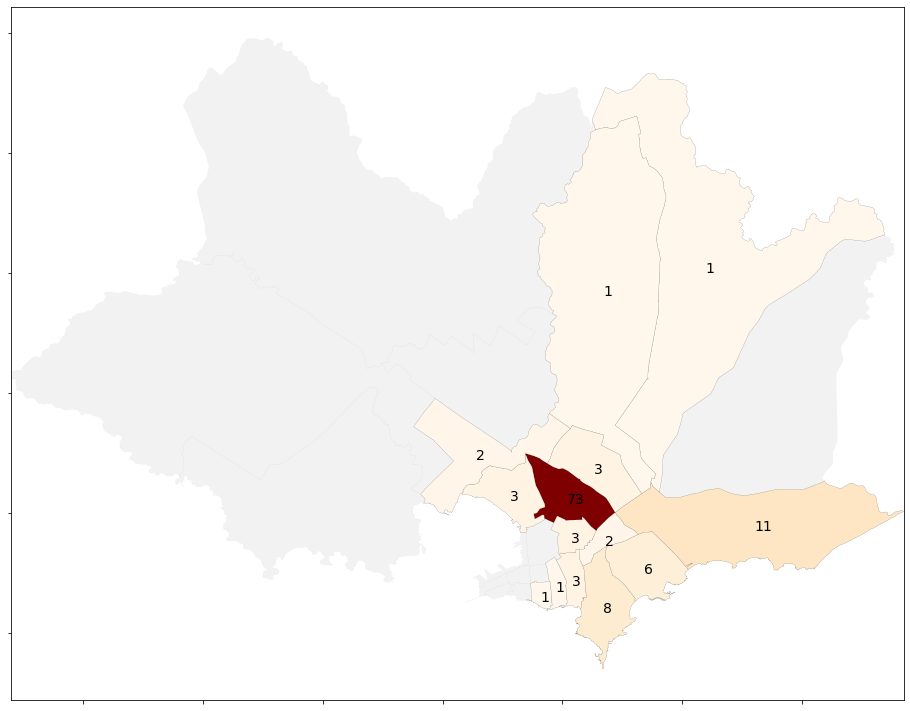

In [60]:
# Map plot
matplotlib.rcParams.update({'font.size': 18})
colormap = cm.OrRd

geodfSecMvd = GeoDataFrame(
    geoSecMvd, geometry=geoSecMvd.geometry
)

geodfSecMvd_cust = pd.merge(
    geoSecMvd,
    cust_by_sec,
    left_on=["DEPTO", "SECCION"],
    right_index=True
)

ax = geodfSecMvd.plot(
    color='grey',
    alpha=.1,
    edgecolor='black',
    linewidth=0.1,
    figsize=(16, 14)
)

ax = geodfSecMvd_cust.plot(
    column='customer_id',
    cmap=colormap,
    alpha=1,
    edgecolor='black',
    linewidth=0.1,
    figsize=(16, 14),
    ax=ax
)

# Print number over sections
for i, sec in geodfSecMvd_cust.iterrows():
    plt.text(
        sec.geometry.centroid.x * 0.9999,
        sec.geometry.centroid.y * 0.99995,
        sec.customer_id,
        fontsize=14,
    )
    
_ = ax.set_xticklabels([])
_ = ax.set_yticklabels([])